In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from sklearn.preprocessing import StandardScaler



# Load the dataset
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)

# Convert y to binary high-income and low-income
y_binary = np.array([1 if income == True else 0 for income in y])

# Train logistic regression classifier
# Predict probabilities
predicts = model.predict(X)
probabilities = model.predict_proba(X)[:, 1]

# Find instances close to the decision boundary (e.g., within 0.05 of 0.5)
boundary_indices = np.where((y == False) & (predicts == 0) & (probabilities > 0.495) & (probabilities < 0.501))[0]

# Find instances close to the decision boundary (e.g., within 0.05 of 0.5)
boundary_indices_high = np.where((y == True) & (predicts == 1) & (probabilities > 0.49) & (probabilities < 0.51))[0]


# Display the indices of boundary instances
print("Indices of examples close to the decision boundary:")
print(boundary_indices)

print("Indices of high income examples close to the decision boundary:")
print(boundary_indices_high)

Indices of examples close to the decision boundary:
[ 779 1368]
Indices of high income examples close to the decision boundary:
[1062]


In [3]:
predicts = model.predict(X)

In [97]:
y[1308]


False

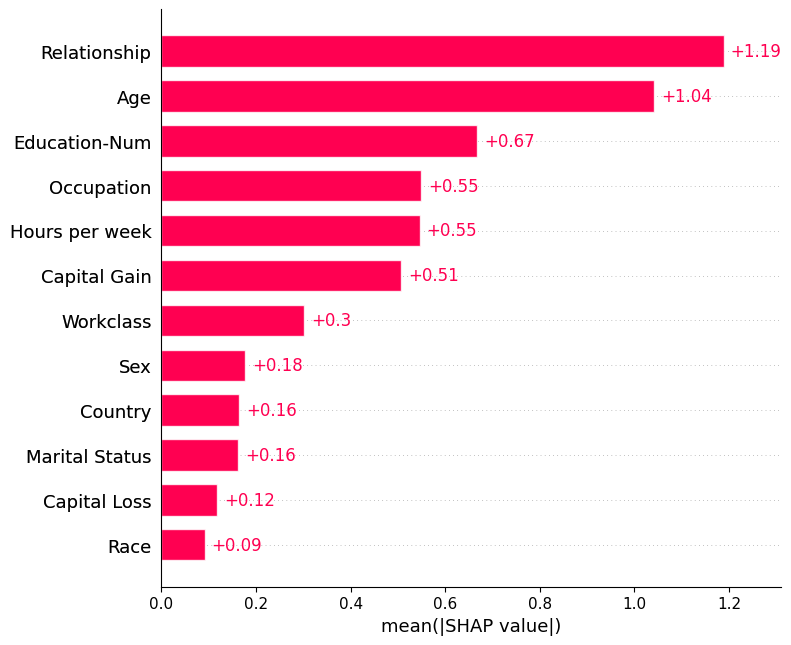

In [4]:
# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.bar(shap_values,max_display=12)

SHAP values for the current instance:


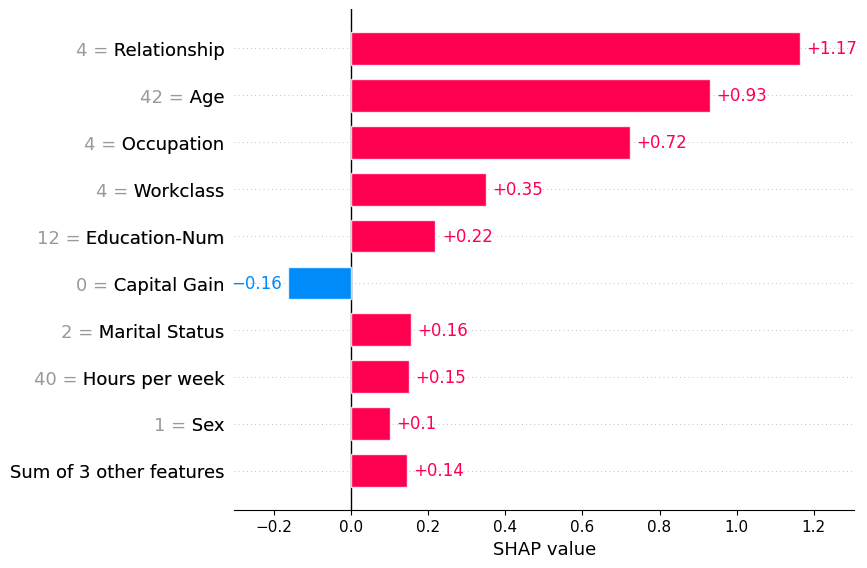

In [5]:
current_instance = X.iloc[100]  # Example: first instance
current_shap_values = shap_values[100]
print("SHAP values for the current instance:")
shap.plots.bar(current_shap_values)

In [6]:
current_shap_values

.values =
array([ 0.93022247,  0.35009296,  0.21841757,  0.15534689,  0.72388488,
        1.16562014,  0.07024311,  0.10113488, -0.1643196 , -0.0173873 ,
        0.14908155,  0.09210933])

.base_values =
-3.034144449280776

.data =
array([42.,  4., 12.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.])

Counterfactual prediction: 1, Counterfactual probability: 0.5103675723075867
The prediction is not flipped. Adjust constraints or bounds and try again.


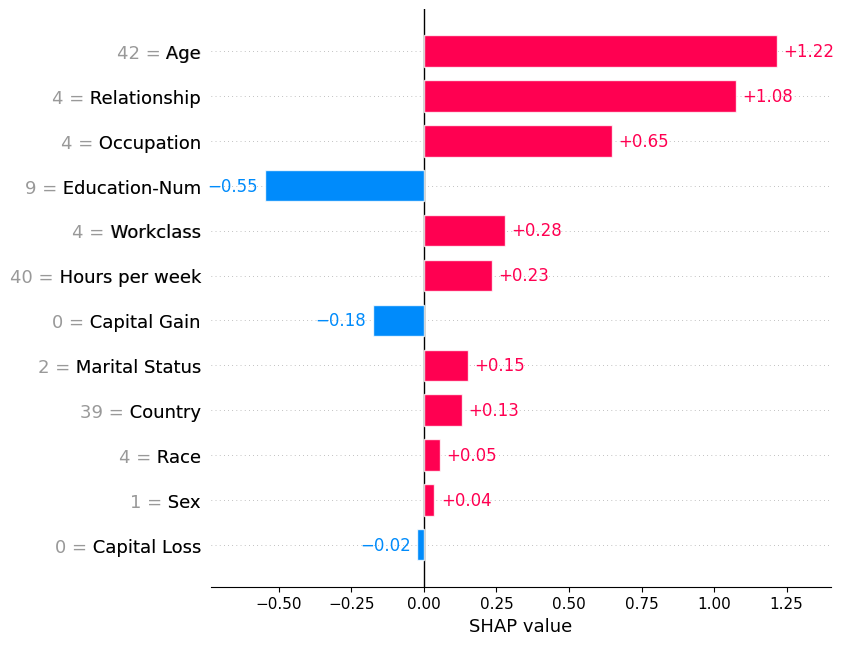

In [18]:

counterfactual_instance = [[42.,  4., 9.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           ]

criticism_case_with_flip_shap_values = [[42.,  4., 8.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           ]

counterfactual_instance_df = pd.DataFrame(counterfactual_instance, columns=X.columns)

criticism_case_with_flip_shap_values_df = pd.DataFrame(criticism_case_with_flip_shap_values, columns=X.columns)
# Predict the outcome for the counterfactual instance
counterfactual_prediction = model.predict(counterfactual_instance_df)[0]
counterfactual_probability = model.predict_proba(counterfactual_instance_df)[0, 1]
print(f"Counterfactual prediction: {counterfactual_prediction}, Counterfactual probability: {counterfactual_probability}")

# Ensure the prediction is flipped
if counterfactual_prediction != True:
    print("The prediction is successfully flipped.")
else:
    print("The prediction is not flipped. Adjust constraints or bounds and try again.")

# Compute SHAP values for the counterfactual instance
counterfactual_shap_values = explainer(counterfactual_instance_df)
criticism_case_with_flip_shap_values = explainer(criticism_case_with_flip_shap_values_df)


shap.plots.bar(counterfactual_shap_values[0],max_display=12)

In [98]:
criticism_instance = X.iloc[1062]  # Example: first instance
criticism_case_shap_values = shap_values[1062]

In [19]:
criticism_case_shap_values = counterfactual_shap_values[0]

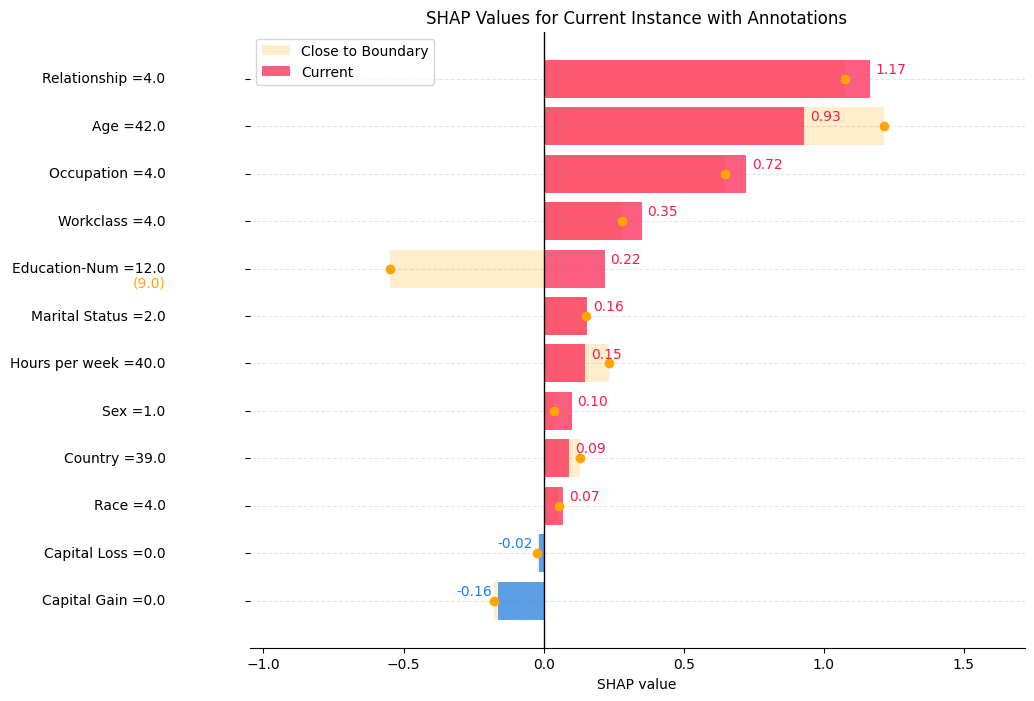

In [17]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and general_case_shap_values are already defined
# And X is the dataset used for feature columns

# Convert SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values,
    'criticism_case_shap_values': counterfactual_shap_values.values,
    'current_feature_value': current_shap_values.data,
    'criticism_case_feature_values': counterfactual_shap_values.data,
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]

# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot general SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['criticism_case_shap_values'], color='orange', alpha=0.2, label='Close to Boundary')

# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, alpha=0.7, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add annotations comparing to the general case
for idx, row in shap_df.iterrows():
    plt.scatter([row['criticism_case_shap_values']], [idx], color='orange', edgecolors='orange', zorder=5)

    # plt.text(row['general_value'], idx + 0.4, f"{row['general_value']:.2f}", color='orange')

# Add feature values next to the y-axis and on the bars
for idx, row in shap_df.iterrows():
    if row['current_value'] >= 0:
        plt.text(row['current_value'] + 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
    else:
        plt.text(row['current_value'] - 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

plt.title('SHAP Values for Current Instance with Annotations')
plt.xlabel('SHAP value')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['criticism_case_shap_values'].min())
max_value = max(shap_df['current_value'].max(), shap_df['criticism_case_shap_values'].max())
for i, row in shap_df.iterrows():
    ax.text(min_value-0.8, i, f"{row['feature']} ={row['current_feature_value']:.1f}", va='center', ha='right', color='black', fontsize=10)
    if row['criticism_case_feature_values'] != row['current_feature_value']:
        ax.text(min_value-0.8, i + 0.3, f"({row['criticism_case_feature_values']:.1f})", va='center', ha='right', color='orange', fontsize=10)

    # ax.text(min_value-0.8, i + 0.3, f"({row['criticism_case_feature_values']:.1f})", va='center', ha='right', color='orange', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value-0.5, right=max_value + 0.5)

# Show the legend
plt.legend()

plt.show()


In [100]:
criticism_case_with_flip = X.iloc[779]  # Example: first instance
criticism_case_with_flip_shap_values = shap_values[779]

In [21]:
criticism_case_with_flip_shap_values = criticism_case_with_flip_shap_values[0]

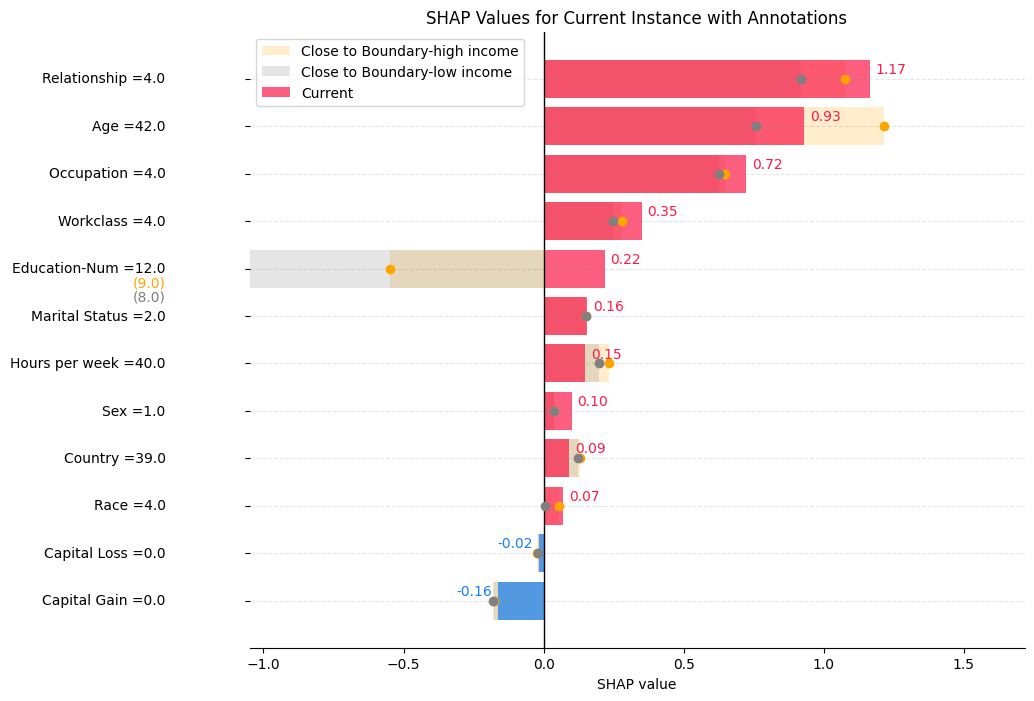

In [23]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and general_case_shap_values are already defined
# And X is the dataset used for feature columns

# Convert SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values,
    'current_feature_value': current_shap_values.data,
    'criticism_case_shap_values': criticism_case_shap_values.values,
    'criticism_case_feature_values': criticism_case_shap_values.data,
    'criticism_case_with_flip_shap_values': criticism_case_with_flip_shap_values.values,
    'criticism_case_with_flip_feature_values': criticism_case_with_flip_shap_values.data,
    
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]

# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot general SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['criticism_case_shap_values'], color='orange', alpha=0.2, label='Close to Boundary-high income')
plt.barh(shap_df['feature'], shap_df['criticism_case_with_flip_shap_values'], color='gray', alpha=0.2, label='Close to Boundary-low income')
# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, alpha=0.7, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add annotations comparing to the general case
for idx, row in shap_df.iterrows():
    plt.scatter([row['criticism_case_shap_values']], [idx], color='orange', edgecolors='orange', zorder=5)
    plt.scatter([row['criticism_case_with_flip_shap_values']], [idx], color='gray', edgecolors='gray', zorder=5)
    # plt.text(row['general_value'], idx + 0.4, f"{row['general_value']:.2f}", color='orange')

# Add feature values next to the y-axis and on the bars
for idx, row in shap_df.iterrows():
    if row['current_value'] >= 0:
        plt.text(row['current_value'] + 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
    else:
        plt.text(row['current_value'] - 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

plt.title('SHAP Values for Current Instance with Annotations')
plt.xlabel('SHAP value')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['criticism_case_shap_values'].min())
max_value = max(shap_df['current_value'].max(), shap_df['criticism_case_shap_values'].max())
for i, row in shap_df.iterrows():
    ax.text(min_value-0.8, i, f"{row['feature']} ={row['current_feature_value']:.1f}", va='center', ha='right', color='black', fontsize=10)
    if row['criticism_case_feature_values'] != row['current_feature_value']:
        ax.text(min_value-0.8, i + 0.3, f"({row['criticism_case_feature_values']:.1f})", va='center', ha='right', color='orange', fontsize=10)
        ax.text(min_value-0.8, i + 0.6, f"({row['criticism_case_with_flip_feature_values']:.1f})", va='center', ha='right', color='gray', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value-0.5, right=max_value + 0.5)

# Show the legend
plt.legend()

plt.show()
